<a href="https://colab.research.google.com/github/kd303/trnsfrmr_pytrch_end_p1/blob/main/session_09_bert/bert_qna/BERT_Tutorial_How_To_Build_a_Question_Answering_Bot_NoLogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [1]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

     |████████████████████████████████| 123 kB 8.4 MB/s 
     |████████████████████████████████| 90 kB 8.7 MB/s 
     |████████████████████████████████| 176 kB 63.8 MB/s 
     |████████████████████████████████| 131 kB 58.2 MB/s 
     |████████████████████████████████| 1.2 MB 51.3 MB/s 
     |████████████████████████████████| 895 kB 48.3 MB/s 
     |████████████████████████████████| 8.5 MB 45.7 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 138 kB 62.8 MB/s 
     |████████████████████████████████| 127 kB 59.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [4]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [6]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'

--2022-01-28 16:41:19--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12493 (12K) [text/plain]
Saving to: ‘utils_squad_evaluate.py’

utils_squad_evaluat 100%[===================>]  12.20K  --.-KB/s    in 0s      

2022-01-28 16:41:19 (84.0 MB/s) - ‘utils_squad_evaluate.py’ saved [12493/12493]



In [ ]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'

In [8]:
!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'

--2022-01-28 16:41:47--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   217MB/s    in 0.2s    

2022-01-28 16:41:48 (217 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]



In [5]:
!ls /drive/My\ Drive/Medium

ls: cannot access '/drive/My Drive/Medium': No such file or directory


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!cp /content/train-v2.0.json /content/drive/MyDrive/bert_data

In [15]:
!cp /content/utils_squad.py /content/drive/MyDrive/bert_data

In [16]:
!cp /content/utils_squad_evaluate.py /content/drive/MyDrive/bert_data

In [13]:
## !mkdir /content/drive/MyDrive/bert_data

In [17]:
!ls /content/drive/MyDrive/bert_data

train-v2.0.json  utils_squad_evaluate.py  utils_squad.py


In [58]:
import sys
sys.path.append('/content/drive/MyDrive/bert_data')

In [3]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
input_file = '/content/drive/MyDrive/bert_data/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [22]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [23]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [25]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
100094,572ba77b34ae481900deaec7,What does Universal Primary Education belong to?,"[Universal, Primary, Education, is, one, of, t...",international Millennium Development Goals,8,11,False
100095,572ba77b34ae481900deaec8,What is one issue that hurts Universal Primary...,"[Universal, Primary, Education, is, one, of, t...",charitable funding,27,28,False
100096,572ba77b34ae481900deaec9,Which organization has discovered corruption i...,"[Universal, Primary, Education, is, one, of, t...",Transparency International,72,73,False
100097,5acd7bf407355d001abf4430,What does Universal Primary Education not belo...,"[Universal, Primary, Education, is, one, of, t...",,-1,-1,True
100098,5acd7bf407355d001abf4431,What is one issue that helps Universal Primar...,"[Universal, Primary, Education, is, one, of, t...",,-1,-1,True
100099,5acd7bf407355d001abf4432,Which organization has not had corruption in t...,"[Universal, Primary, Education, is, one, of, t...",,-1,-1,True
100100,5acd7bf407355d001abf4433,What parents do not give pressure to their chi...,"[Universal, Primary, Education, is, one, of, t...",,-1,-1,True
100101,5acd7bf407355d001abf4434,Who should earn money in the long term instead...,"[Universal, Primary, Education, is, one, of, t...",,-1,-1,True


In [26]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [27]:
print_squad_sample(train_data)

CONTEXT: 
English Dominican mysticism in the late medieval period differed from European strands of it
in that, whereas European Dominican mysticism tended to concentrate on ecstatic experiences of union
with the divine, English Dominican mysticism's ultimate focus was on a crucial dynamic in
one's personal relationship with God. This was an essential moral imitation of the Savior
as an ideal for religious change, and as the means for reformation of humanity's
nature as an image of divinity. This type of mysticism carried with it four
elements. First, spiritually it emulated the moral essence of Christ's life. Second, there was
a connection linking moral emulation of Christ's life and humanity's disposition as images of
the divine. Third, English Dominican mysticism focused on an embodied spirituality with a structured
love of fellow men at its center. Finally, the supreme aspiration of this mysticism
was either an ethical or an actual union with God.
QUESTION:                         

In [28]:
len

<function len>

In [29]:

train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
12831,56df25da3277331400b4d9b1,When was Sony's new logo revealed to the public?,"[On, August, 5,, 2008,, SCA, and, Bertelsmann,...",2009,113,113,False,114,48
26719,56fa81d38f12f31900630165,What format did the first European HDTV broadc...,"[These, first, European, HDTV, broadcasts, use...",1080i format,7,8,False,40,54
65350,5a1e07ce3de3f40018b26453,What term referred to a set of temporary insti...,"[These, theorists, were, driven, by, two, basi...",,-1,-1,True,204,116
7455,5a591d523e1742001a15cf9e,What discussion about botany terms was taking ...,"[The, term, was, created, in, 1920, by, Hans, ...",,-1,-1,True,60,60
75807,5727db08ff5b5019007d96f4,What did Darwin do to show that he admired the...,"[Natural, theology, was, not, a, unified, doct...","Darwin quoted Kingsley as ""a celebrated cleric...",73,90,False,157,72


In [7]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

NameError: ignored

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 32 ## 16 // 64

In [9]:
cached_features_file = '/content/drive/MyDrive/bert_data/cached_features.json'

In [10]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [11]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [12]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [13]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [14]:
import glob
checkpoints = sorted(glob.glob('/content/drive/MyDrive/bert_data/model-ckp/checkpoint*-[0-9]*'))

In [15]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [16]:
print(checkpoints)

[]


In [17]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/content/drive/MyDrive/bert_data/model-ckp/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [18]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0226,  0.0073, -0.0102,  ...,  0.0167, -0.0311, -0.0112],
        [ 0.0243, -0.0141, -0.0268,  ..., -0.0019, -0.0300,  0.0087]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [19]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [52]:
batch_size = 16 ## 16 // 64

In [ ]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/content/drive/MyDrive/bert_data/model-ckp/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

In [23]:
output_dir = '/content/drive/MyDrive/bert_data/chkpnt-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [32]:
!cd /content/drive/MyDrive/bert_data/

In [33]:
!cp /content/dev-v2.0.json /content/drive/MyDrive/bert_data/

In [26]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2022-01-28 18:31:28--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       100%[===================>]   4.17M  --.-KB/s    in 0.05s   

2022-01-28 18:31:28 (85.9 MB/s) - ‘dev-v2.0.json’ saved [4370528/4370528]



In [28]:
train_loss_set_ckpt = torch.load('/content/drive/MyDrive/bert_data/model-ckp/checkpoint-4000/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

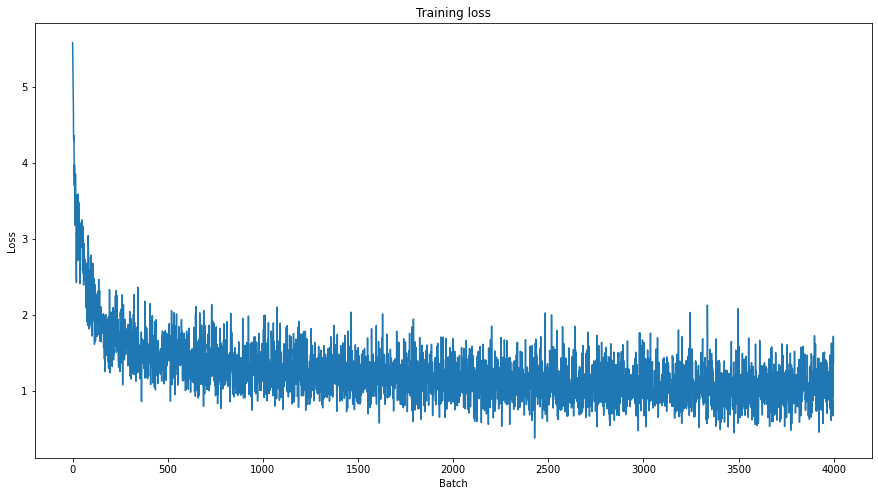

In [29]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [59]:
input_file = '/content/drive/MyDrive/bert_data/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/content/drive/MyDrive/bert_data/cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [60]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [61]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [40]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/drive/MyDrive/bert_data/dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/content/drive/MyDrive/bert_data/predictions.json"
  output_nbest_file = "/content/drive/MyDrive/bert_data/nbest_predictions.json"
  output_null_log_odds_file = "/content/drive/MyDrive/bert_data/null_odds.json"
  output_dir = "/content/drive/MyDrive/bert_data/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [41]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 32


Evaluating: 100%|██████████| 425/425 [02:01<00:00,  3.50it/s]


{
  "exact": 70.3697464836183,
  "f1": 73.58668968300192,
  "total": 11873,
  "HasAns_exact": 64.49055330634278,
  "HasAns_f1": 70.93366508203107,
  "HasAns_total": 5928,
  "NoAns_exact": 76.23212783851976,
  "NoAns_f1": 76.23212783851976,
  "NoAns_total": 5945,
  "best_exact": 70.54661837783206,
  "best_exact_thresh": -0.3960533142089844,
  "best_f1": 73.61606612222818,
  "best_f1_thresh": -0.23991966247558594
}


In [42]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 70.3697464836183}, {'f1': 73.58668968300192}, {'total': 11873}, {'HasAns_exact': 64.49055330634278}, {'HasAns_f1': 70.93366508203107}, {'HasAns_total': 5928}, {'NoAns_exact': 76.23212783851976}, {'NoAns_f1': 76.23212783851976}, {'NoAns_total': 5945}, {'best_exact': 70.54661837783206}, {'best_exact_thresh': -0.3960533142089844}, {'best_f1': 73.61606612222818}, {'best_f1_thresh': -0.23991966247558594}]


**Evaluate on any text**

In [ ]:
# print predictions vs actuals
prediction_file = '/content/drive/MyDrive/bert_data/predictions.json'
with open(prediction_file, "r", encoding='utf-8') as reader:
 pred_data = json.load(reader)
 print(type(pred_data))
 for entry in pred_data:
   for sq_example in val_examples:
     if sq_example.qas_id == entry:
       print(sq_example.qas_id, 'pred :', pred_data[entry], 'actual : ', sq_example.orig_answer_text)
       break

In [ ]:
for example in val_examples:
  # print(example)
  print(example.qas_id,example.question_text, example.orig_answer_text)